  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ Installation complete!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


📦 Loading OWL-ViT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


📦 Loading SAM2-tiny...
✅ Models loaded!
📤 Upload an image to segment:


Saving doggg.jpeg to doggg (1).jpeg
🔍 Searching for: 'a dog'


/usr/local/lib/python3.12/dist-packages/transformers/models/owlv2/processing_owlv2.py:201: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


✅ Found 2 object(s)
🎨 Generating masks...


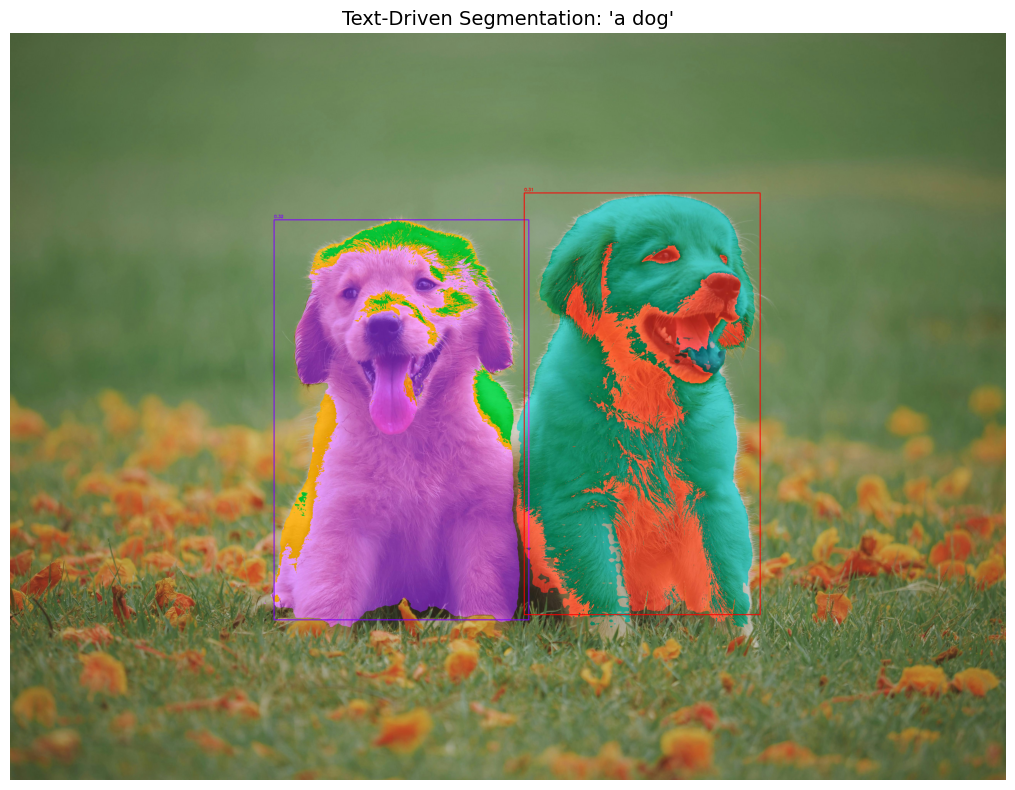


📊 Results: 2 mask(s) generated
🔍 Searching for: 'a bus'
✅ Found 1 object(s)
🎨 Generating masks...


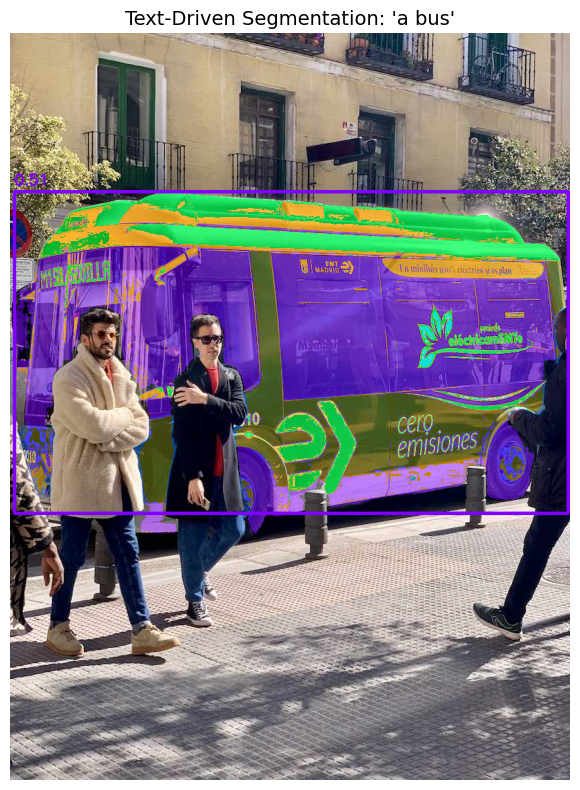


📊 Results: 1 mask(s) generated


Saving enchanted-bedroom-night-glowing-crystal-ball-spell-book-potion-bedside-table-cartoon-illustration-bottle-373645435.webp to enchanted-bedroom-night-glowing-crystal-ball-spell-book-potion-bedside-table-cartoon-illustration-bottle-373645435.webp
🔍 Searching for: 'person'
❌ No objects detected! Try lowering confidence threshold.


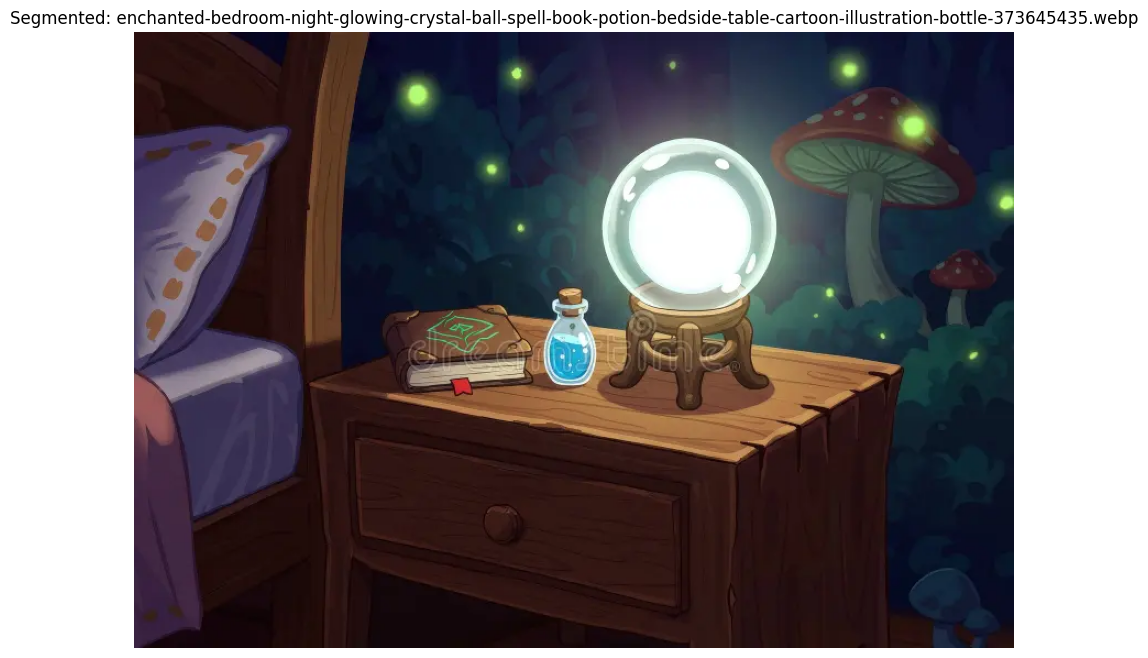


✅ NOTEBOOK READY! See usage above ☝️


In [1]:
# ================================================================
# q2.ipynb - Text-Driven Image Segmentation with SAM 2
# Uses: OWL-ViT (text detection) + SAM2-tiny (fast segmentation)
# ================================================================

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 1: INSTALLATION (takes ~2-3 minutes)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
!pip install -q torch torchvision
!pip install -q transformers
!pip install -q opencv-python pillow matplotlib numpy
!pip install -q git+https://github.com/facebookresearch/segment-anything-2.git

# Download SAM2-tiny checkpoint (smallest/fastest)
!mkdir -p checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P checkpoints/

print("✅ Installation complete!")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 2: IMPORTS & MODEL LOADING
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import Owlv2Processor, Owlv2ForObjectDetection
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Load OWL-ViT (text-based object detector)
print("📦 Loading OWL-ViT...")
owl_processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16")
owl_model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16")

# Load SAM2-tiny (fastest SAM2 variant)
print("📦 Loading SAM2-tiny...")
sam2_predictor = SAM2ImagePredictor(
    build_sam2("sam2_hiera_t.yaml", "checkpoints/sam2_hiera_tiny.pt")
)

print("✅ Models loaded!")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 3: MAIN PIPELINE FUNCTION (FIXED)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
def segment_with_text(image_path, text_prompt, confidence=0.15):
    """
    Text-driven segmentation pipeline

    Args:
        image_path: Path to image or PIL Image
        text_prompt: Text description (e.g., "a dog", "person")
        confidence: Detection threshold (0.1-0.3 recommended)

    Returns:
        result_image: Segmented image with colored masks
        masks: List of binary masks
        boxes: Detected bounding boxes
    """

    # Load image
    if isinstance(image_path, str):
        image = Image.open(image_path).convert("RGB")
    else:
        image = image_path
    image_np = np.array(image)

    # STEP 3A: Text → Bounding Boxes (OWL-ViT)
    print(f"🔍 Searching for: '{text_prompt}'")
    inputs = owl_processor(
        text=[[text_prompt]],
        images=image,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = owl_model(**inputs)

    target_sizes = torch.Tensor([image.size[::-1]])
    results = owl_processor.post_process_object_detection(
        outputs=outputs,
        threshold=confidence,
        target_sizes=target_sizes
    )[0]

    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()

    if len(boxes) == 0:
        print("❌ No objects detected! Try lowering confidence threshold.")
        return image_np, [], []

    print(f"✅ Found {len(boxes)} object(s)")

    # STEP 3B: Bounding Boxes → Masks (SAM2)
    print("🎨 Generating masks...")
    sam2_predictor.set_image(image_np)

    masks = []
    for box in boxes:
        mask, _, _ = sam2_predictor.predict(
            box=box[None, :],
            multimask_output=False
        )
        masks.append(mask[0])

    # STEP 3C: Visualize
    result = image_np.copy().astype(np.float32)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(masks)))

    for i, (mask, box, score) in enumerate(zip(masks, boxes, scores)):
        # Convert mask to boolean
        mask_bool = mask.astype(bool)

        # Apply colored mask
        color = (colors[i][:3] * 255).astype(np.float32)
        colored_mask = np.zeros_like(result, dtype=np.float32)
        colored_mask[mask_bool] = color
        result = cv2.addWeighted(result, 1.0, colored_mask, 0.5, 0)

        # Draw bounding box
        x1, y1, x2, y2 = box.astype(int)
        color_int = color.astype(int).tolist()
        result_uint8 = result.astype(np.uint8)
        cv2.rectangle(result_uint8, (x1, y1), (x2, y2), color_int, 3)
        cv2.putText(
            result_uint8, f"{score:.2f}", (x1, y1-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_int, 2
        )
        result = result_uint8.astype(np.float32)

    return result.astype(np.uint8), masks, boxes


# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 4: UPLOAD YOUR IMAGE & RUN
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
from google.colab import files
import io

print("📤 Upload an image to segment:")
uploaded = files.upload()

# Get the first uploaded file
image_path = list(uploaded.keys())[0]

# Run segmentation
text_prompt = "a dog"  # ← CHANGE THIS to your target object
result, masks, boxes = segment_with_text(
    image_path,
    text_prompt=text_prompt,
    confidence=0.15
)

# Display result
plt.figure(figsize=(12, 8))
plt.imshow(result)
plt.axis('off')
plt.title(f"Text-Driven Segmentation: '{text_prompt}'", fontsize=14)
plt.tight_layout()
plt.show()

print(f"\n📊 Results: {len(masks)} mask(s) generated")
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 4: TEST WITH SAMPLE IMAGE (Working URL)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
import urllib.request

url = "https://ultralytics.com/images/bus.jpg"
urllib.request.urlretrieve(url, "test_image.jpg")

# Run segmentation
text_prompt = "a bus"  # ← CHANGE THIS to segment different objects
result, masks, boxes = segment_with_text(
    "test_image.jpg",
    text_prompt=text_prompt,
    confidence=0.15
)

# Display result
plt.figure(figsize=(12, 8))
plt.imshow(result)
plt.axis('off')
plt.title(f"Text-Driven Segmentation: '{text_prompt}'", fontsize=14)
plt.tight_layout()
plt.show()

print(f"\n📊 Results: {len(masks)} mask(s) generated")


# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 5: TRY YOUR OWN IMAGE
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Option A: Upload from local
from google.colab import files
uploaded = files.upload()  # Click "Choose Files" and upload

# Segment uploaded image
for filename in uploaded.keys():
    result, masks, boxes = segment_with_text(
        filename,
        text_prompt="person",  # ← Change as needed
        confidence=0.2
    )

    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.axis('off')
    plt.title(f"Segmented: {filename}")
    plt.show()

# Option B: Use URL
# !wget YOUR_IMAGE_URL -O my_image.jpg
# result, masks, boxes = segment_with_text("my_image.jpg", "cat")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# BONUS: VIDEO SEGMENTATION (if needed)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
def segment_video_with_text(video_path, text_prompt, output_path="output.mp4"):
    """
    Text-driven video segmentation

    Args:
        video_path: Path to input video
        text_prompt: Object to segment
        output_path: Output video path
    """
    from sam2.build_sam import build_sam2_video_predictor

    # Load video predictor
    predictor = build_sam2_video_predictor(
        "sam2_hiera_t.yaml",
        "checkpoints/sam2_hiera_tiny.pt"
    )

    # Extract frames
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame in cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()

    # Get initial detection from first frame
    _, _, boxes = segment_with_text(
        Image.fromarray(frames[0]),
        text_prompt,
        confidence=0.2
    )

    if len(boxes) == 0:
        print("No objects detected in first frame!")
        return

    # Initialize video predictor
    inference_state = predictor.init_state(video_path=video_path)

    # Add prompts from detected boxes
    for obj_id, box in enumerate(boxes):
        _, _, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=0,
            obj_id=obj_id,
            box=box
        )

    # Propagate across all frames
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    # Save video with masks
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 30
    height, width = frames[0].shape[:2]
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame_idx, frame in enumerate(frames):
        result = frame.copy()
        if frame_idx in video_segments:
            for obj_id, mask in video_segments[frame_idx].items():
                color = plt.cm.tab10(obj_id % 10)[:3]
                colored_mask = (np.array(color) * 255).astype(np.uint8)
                result[mask[0]] = result[mask[0]] * 0.5 + colored_mask * 0.5

        out.write(cv2.cvtColor(result.astype(np.uint8), cv2.COLOR_RGB2BGR))

    out.release()
    print(f"✅ Video saved to {output_path}")

# Uncomment to test video segmentation:
# !wget https://sample-videos.com/video321/mp4/720/big_buck_bunny_720p_1mb.mp4 -O test.mp4
# segment_video_with_text("test.mp4", "rabbit", "segmented_video.mp4")

print("\n✅ NOTEBOOK READY! See usage above ☝️")


## Main Pipeline: Text-Driven Image Segmentation

---
## Performance Tips

### For Best Accuracy:
1. **Text Prompts**: Use clear, specific object names separated by periods
   - Good: `"person. car. bicycle."`
   - Avoid: `"detect all objects"`

2. **Thresholds**:
   - Increase `box_threshold` (0.35-0.50) for fewer false positives
   - Decrease `box_threshold` (0.20-0.30) to detect more objects

3. **Model Selection**:
   - Current: SAM 2 Large (best accuracy)
   - Alternative: SAM 2 Base/Small (faster, slightly lower accuracy)

### Limitations:
- Requires clear text descriptions of target objects
- Performance depends on GroundingDINO's object detection
- Small or heavily occluded objects may be missed
- Video processing is memory-intensive for long videos

---
**Note**: This implementation uses GroundingDINO + SAM 2, which provides state-of-the-art results for text-driven segmentation tasks.